# Imports

In [1]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV, RandomizedSearchCV
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
import numpy as np
import os

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, recall_score

# Data cleaning

## Visualisation

In [2]:
df = pd.read_csv(filepath_or_buffer='healthcare-dataset-stroke-data.csv',
                 true_values=['Yes'],
                 false_values=['No'],
                 na_values=['N/A', 'Unknown'],
                 ).drop('id', axis=1)

In [3]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,True,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,True,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,True,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,True,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,True,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   bool   
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     3566 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: bool(1), float64(3), int64(3), object(4)
memory usage: 404.3+ KB


In [5]:
df = df.dropna(how='any', axis=0)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3426 entries, 0 to 5108
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3426 non-null   object 
 1   age                3426 non-null   float64
 2   hypertension       3426 non-null   int64  
 3   heart_disease      3426 non-null   int64  
 4   ever_married       3426 non-null   bool   
 5   work_type          3426 non-null   object 
 6   Residence_type     3426 non-null   object 
 7   avg_glucose_level  3426 non-null   float64
 8   bmi                3426 non-null   float64
 9   smoking_status     3426 non-null   object 
 10  stroke             3426 non-null   int64  
dtypes: bool(1), float64(3), int64(3), object(4)
memory usage: 297.8+ KB


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'hypertension'}>],
       [<Axes: title={'center': 'heart_disease'}>,
        <Axes: title={'center': 'avg_glucose_level'}>],
       [<Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'stroke'}>]], dtype=object)

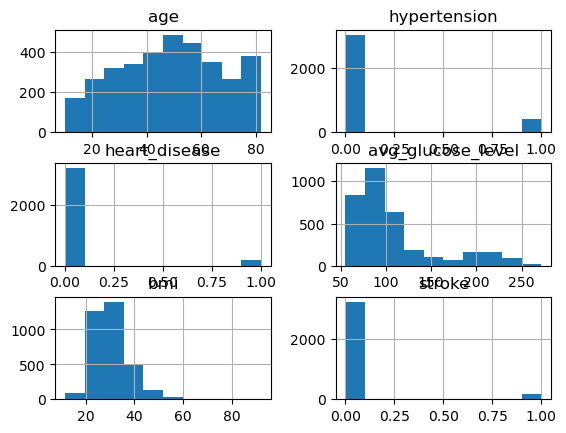

In [7]:
df.hist()

In [8]:
numerical = [col for col in df.columns if df[col].dtype=='float64' and col !='stroke']
categorical = [col for col in df.columns if (df[col].dtype==object or df[col].dtype=='int64' or df[col].dtype==bool) and col !='stroke']

In [9]:
numerical

['age', 'avg_glucose_level', 'bmi']

In [10]:
categorical

['gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status']

## Splitting

In [11]:
X = df.drop('stroke', axis=1)
y = df['stroke']

In [12]:
y.value_counts()

stroke
0    3246
1     180
Name: count, dtype: int64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=38)

## Preprocessing

In [14]:
col_tr = ColumnTransformer([
    ['num', StandardScaler(), numerical],
    ['cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary').set_output(transform='pandas'), categorical]
])

In [15]:
X_train = col_tr.fit_transform(X_train)
X_test = col_tr.transform(X_test)

# Rapid test of models

In [16]:
models = [LogisticRegression(), RidgeClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), SVC()]

In [17]:
result_rapid = {}

In [18]:
for model in models:
    print(f'Studying model {model} ...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        result_rapid[str(model)] = (f1_score(y_test, y_pred), recall_score(y_test, y_pred))
        print('Results saved in dict.')
    except ValueError as e:
        print(f'There was a ValueError:\n{e}\nThe predicted values were stored instead of the scores.')
        result_rapid[str(model)] = y_pred
    

Studying model LogisticRegression() ...
Results saved in dict.
Studying model RidgeClassifier() ...
Results saved in dict.
Studying model DecisionTreeClassifier() ...
Results saved in dict.
Studying model RandomForestClassifier() ...
Results saved in dict.
Studying model GradientBoostingClassifier() ...
Results saved in dict.
Studying model SVC() ...
Results saved in dict.


In [19]:
for k,v in result_rapid.items():
    if type(v) != np.array:
        print(f'The model {k} gave the following results:')
        print(f'F1 score: {v[0]:.2f}')
        print(f'Recall: {v[1]:.2f}')

The model LogisticRegression() gave the following results:
F1 score: 0.04
Recall: 0.02
The model RidgeClassifier() gave the following results:
F1 score: 0.00
Recall: 0.00
The model DecisionTreeClassifier() gave the following results:
F1 score: 0.12
Recall: 0.11
The model RandomForestClassifier() gave the following results:
F1 score: 0.04
Recall: 0.02
The model GradientBoostingClassifier() gave the following results:
F1 score: 0.04
Recall: 0.02
The model SVC() gave the following results:
F1 score: 0.00
Recall: 0.00


# Random Forest Classifier

## Using GridSearchCV

In [20]:
forestclf = RandomForestClassifier(random_state=38, class_weight='balanced')

In [21]:
param_grid = {
    'n_estimators':[10,100,500,1000],
    'max_depth':[3,5,10,15,20,None],
    'min_samples_split':[2,3],
    'min_samples_leaf':[1,2,3]
}

In [22]:
grid = GridSearchCV(
    estimator=forestclf,
    scoring='f1',
    param_grid=param_grid,
    return_train_score=True,
    cv=5,
    n_jobs=-1,
    verbose=3
)

In [23]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=0.256, test=0.240) total time=   0.0s
[CV 3/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=0.266, test=0.223) total time=   0.0s
[CV 2/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=0.290, test=0.228) total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=0.246, test=0.173) total time=   0.0s[CV 5/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=0.275, test=0.193) total time=   0.0s

[CV 4/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.286, test=0.249) total time=   0.2s
[CV 5/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.295, test=0.219) to

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=38),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 15, 20, None],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [10, 100, 500, 1000]},
             return_train_score=True, scoring='f1', verbose=3)

In [25]:
df_grid = pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')
df_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
37,0.282709,0.013701,0.015288,0.000509,5,2,3,100,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s...",0.293578,...,0.275242,0.022976,1,0.369168,0.369295,0.376569,0.377593,0.387665,0.376058,0.006791
33,0.264946,0.003845,0.014633,0.000172,5,2,2,100,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s...",0.293578,...,0.275242,0.022976,1,0.369168,0.369295,0.376569,0.377593,0.387665,0.376058,0.006791
41,0.276461,0.009005,0.016357,0.002282,5,3,2,100,"{'max_depth': 5, 'min_samples_leaf': 3, 'min_s...",0.304762,...,0.272503,0.029964,3,0.374745,0.373166,0.378947,0.372951,0.391209,0.378204,0.006850
45,0.283268,0.004816,0.015899,0.000450,5,3,3,100,"{'max_depth': 5, 'min_samples_leaf': 3, 'min_s...",0.304762,...,0.272503,0.029964,3,0.374745,0.373166,0.378947,0.372951,0.391209,0.378204,0.006850
29,0.265597,0.009480,0.014813,0.000890,5,1,3,100,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.299065,...,0.269976,0.020726,5,0.372951,0.369168,0.371134,0.374486,0.396437,0.376835,0.009961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.327049,0.009697,0.016589,0.000202,20,1,2,100,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.000000,...,0.000000,0.000000,136,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
96,0.035168,0.000483,0.005014,0.000051,20,1,2,10,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.000000,...,0.000000,0.000000,136,0.897959,0.880829,0.914573,0.892308,0.875000,0.892134,0.013848
121,0.328600,0.003310,0.016488,0.000075,None,1,2,100,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.000000,...,0.000000,0.000000,136,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
120,0.035194,0.000837,0.005082,0.000664,None,1,2,10,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.000000,...,0.000000,0.000000,136,0.903553,0.880829,0.914573,0.897959,0.875000,0.894383,0.014587


## Using RandomizedSearchCV

In [29]:
forestclf = RandomForestClassifier(random_state=38, class_weight='balanced')

param_grid = {
    'n_estimators':[10,100,500,1000],
    'max_depth':[3,5,10,15,20,None],
    'min_samples_split':[2,3],
    'min_samples_leaf':[1,2,3]
}

In [30]:
rdmcv = RandomizedSearchCV(
    estimator=forestclf,
    scoring='f1',
    param_distributions=param_grid,
    n_iter=77,
    return_train_score=True,
    cv=5,
    n_jobs=-1,
    verbose=3
)

In [31]:
rdmcv.fit(X_train,y_train)

Fitting 5 folds for each of 77 candidates, totalling 385 fits
[CV 2/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=0.904, test=0.000) total time=   0.0s
[CV 1/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=0.920, test=0.067) total time=   0.0s
[CV 2/5] END max_depth=15, min_samples_leaf=2, min_samples_split=3, n_estimators=10;, score=(train=0.883, test=0.217) total time=   0.0s
[CV 3/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=0.915, test=0.000) total time=   0.1s
[CV 4/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=0.882, test=0.059) total time=   0.1s
[CV 1/5] END max_depth=15, min_samples_leaf=2, min_samples_split=3, n_estimators=10;, score=(train=0.847, test=0.195) total time=   0.1s
[CV 3/5] END max_depth=15, min_samples_leaf=2, min_samples_split=3, n_estimators=10;, score=(train=0.857, test=0.125

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=38),
                   n_iter=77, n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 10, 15, 20, None],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 3],
                                        'n_estimators': [10, 100, 500, 1000]},
                   return_train_score=True, scoring='f1', verbose=3)

In [32]:
df_rdmcv = pd.DataFrame(rdmcv.cv_results_).sort_values(by='rank_test_score')
df_rdmcv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
41,0.287961,0.017590,0.015897,0.001352,100,3,2,5,"{'n_estimators': 100, 'min_samples_split': 3, ...",0.293578,...,0.275242,0.022976,1,0.369168,0.369295,0.376569,0.377593,0.387665,0.376058,0.006791
4,0.284269,0.012332,0.016643,0.002328,100,3,3,5,"{'n_estimators': 100, 'min_samples_split': 3, ...",0.304762,...,0.272503,0.029964,2,0.374745,0.373166,0.378947,0.372951,0.391209,0.378204,0.006850
5,0.271283,0.008432,0.015920,0.000878,100,2,1,5,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.301887,...,0.263281,0.025734,3,0.379958,0.371308,0.366255,0.369168,0.399093,0.377157,0.011882
63,1.330140,0.038040,0.065050,0.005611,500,3,1,5,"{'n_estimators': 500, 'min_samples_split': 3, ...",0.265487,...,0.256705,0.012085,4,0.365112,0.357143,0.358268,0.358974,0.387097,0.365319,0.011235
72,1.163226,0.030100,0.056969,0.002289,500,2,2,3,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.285714,...,0.255085,0.027678,5,0.283019,0.285714,0.267054,0.270349,0.276730,0.276573,0.007134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,3.267003,0.070643,0.143488,0.012858,1000,2,1,15,"{'n_estimators': 1000, 'min_samples_split': 2,...",0.000000,...,0.013333,0.026667,72,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
42,1.618133,0.033769,0.072206,0.002974,500,2,1,None,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.000000,...,0.000000,0.000000,74,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
33,0.332845,0.008208,0.017376,0.000959,100,2,1,20,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.000000,...,0.000000,0.000000,74,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
26,1.645959,0.066354,0.070242,0.001552,500,2,1,20,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.000000,...,0.000000,0.000000,74,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
